In [1]:
!pip install spotipy scikit-learn tensorflow keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 7.2 MB/s eta 0:00:00


In [4]:
df = pd.read_csv("SpotifyFeatures.csv.csv")
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [5]:
features = ['acousticness','danceability','energy','instrumentalness',
            'liveness','loudness','speechiness','tempo','valence']

X = df[features].fillna(0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape:", X_scaled.shape)


Shape: (232725, 9)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(X_scaled.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_scaled, X_scaled, epochs=5, batch_size=256, validation_split=0.1)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


819/819 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7110 - mae: 0.6395 - val_loss: 0.4723 - val_mae: 0.4789
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5722 - mae: 0.5396 - val_loss: 0.4715 - val_mae: 0.4768
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5694 - mae: 0.5341 - val_loss: 0.4710 - val_mae: 0.4747
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5675 - mae: 0.5295 - val_loss: 0.4704 - val_mae: 0.4715
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5640 - mae: 0.5239 - val_loss: 0.4698 - val_mae: 0.4686


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend(song_index, top_n=5):
    song_vec = X_scaled[song_index].reshape(1, -1)
    embedding = model.predict(song_vec)
    similarity = cosine_similarity(embedding, X_scaled)[0]

    indices = similarity.argsort()[-top_n-1:][::-1]
    indices = [i for i in indices if i != song_index][:top_n]

    return df.iloc[indices][['track_name','artist_name','genre','danceability','energy','tempo']]

# Example: recommend for the 10th song
recommend(10, top_n=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


,track_name,artist_name,genre,danceability,energy,tempo
74257,Toot the Flute (Instrumental),Kimbo Children's Music,Children's Music,0.567,0.565,128.493
62038,Flamingo,Fruit Bats,Folk,0.622,0.551,119.610
76970,Incy Wincy Spider,Preschool Kids,Children's Music,0.655,0.474,122.908
76803,Incy Wincy Spider,Nursery Rhymes ABC,Children's Music,0.655,0.474,122.908
202098,Secret Melody,Thomas Bergersen,Soundtrack,0.570,0.487,115.021


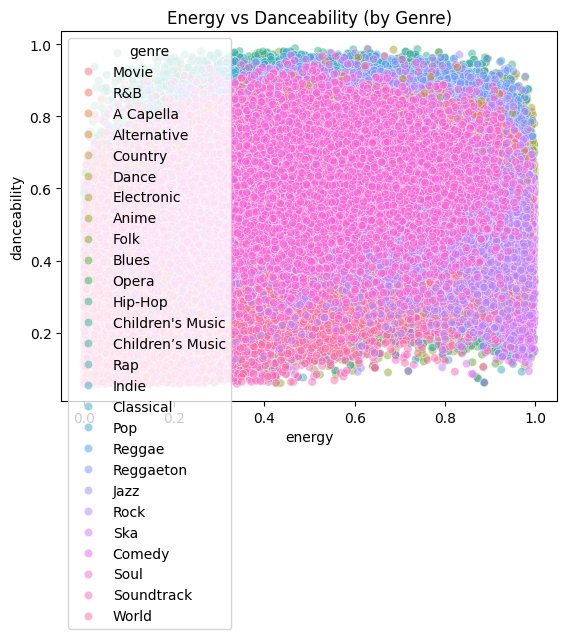

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=df['energy'], y=df['danceability'], hue=df['genre'], alpha=0.5)
plt.title("Energy vs Danceability (by Genre)")
plt.show()
